Pares encontrados: 3


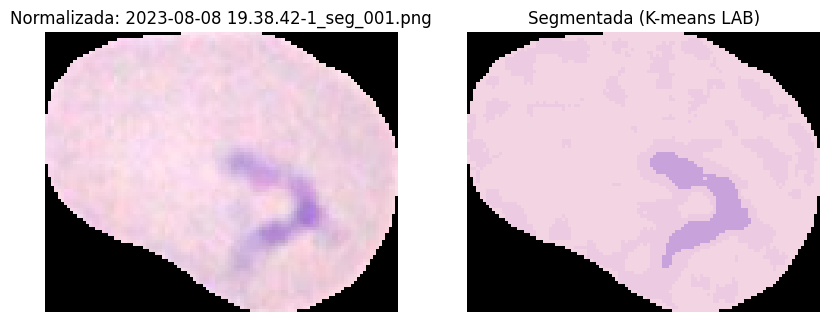

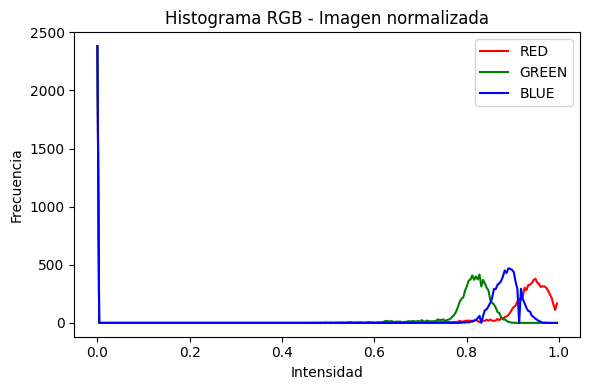

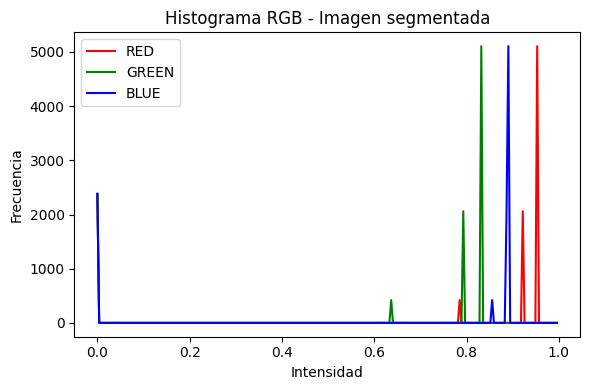

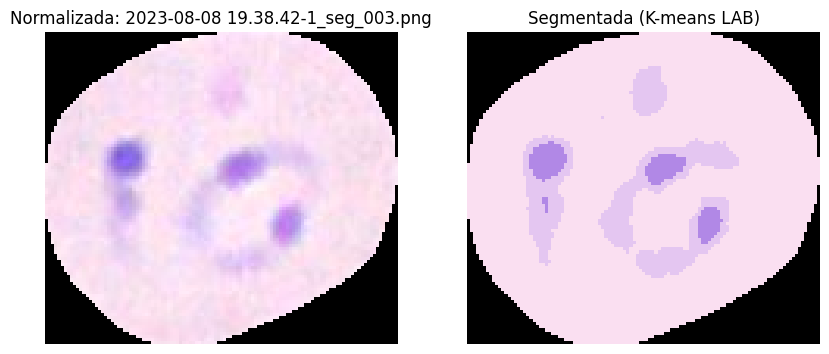

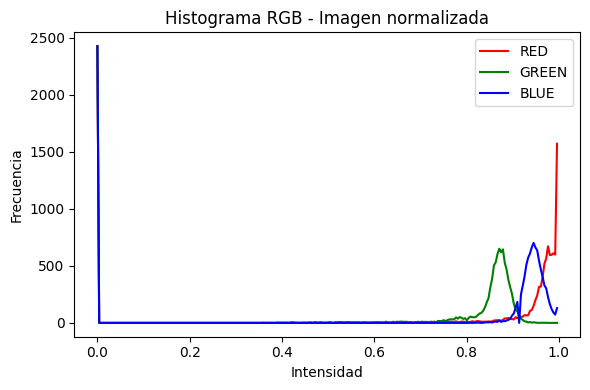

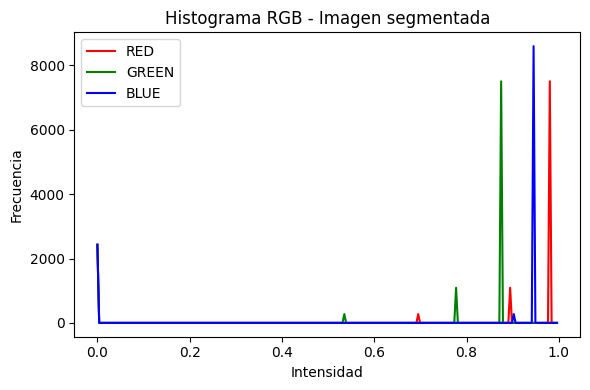

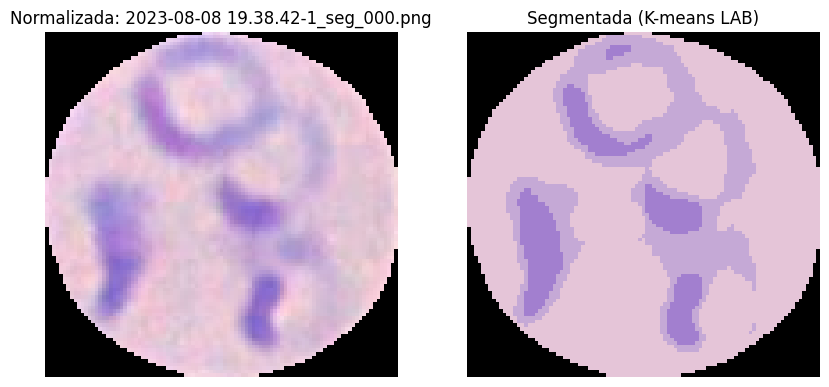

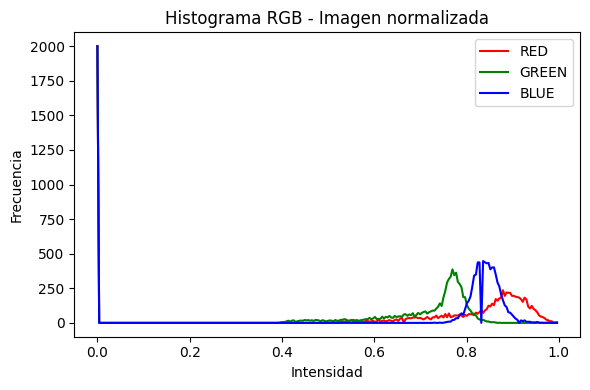

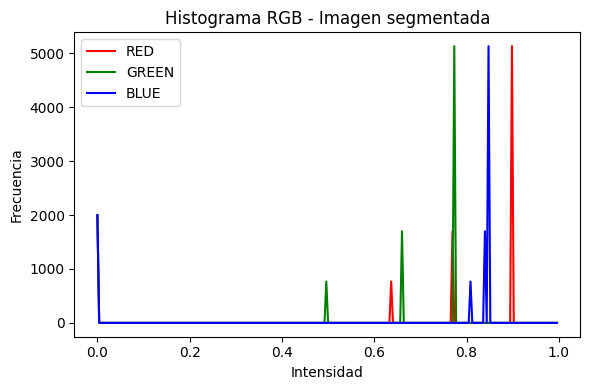

In [8]:
from pathlib import Path
import numpy as np
import cv2
from skimage import color as skcolor, img_as_ubyte
import matplotlib.pyplot as plt
import glob, os

def read_rgb_float01(path: str):
    arr = cv2.imread(path, cv2.IMREAD_COLOR)
    if arr is None:
        raise FileNotFoundError(f"No se puede leer: {path}")
    arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
    return (arr.astype(np.float32) / 255.0)

def normalize_img(img: np.ndarray, rimg: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    norm = img / (rimg + eps)
    norm = np.nan_to_num(norm, nan=0.0, posinf=0.0, neginf=0.0)
    return np.clip(norm, 0.0, 1.0).astype(np.float32)

def kmeans_lab_segments(rgb_float: np.ndarray, K: int = 4, max_iter: int = 60, attempts: int = 20):
    lab = skcolor.rgb2lab(rgb_float)
    h, w, _ = lab.shape
    samples = lab.reshape((-1, 3)).astype(np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 1.0)
    compactness, labels, centers = cv2.kmeans(samples, K, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
    labels = labels.flatten()
    segmented_lab = centers[labels].reshape((h, w, 3))
    return labels, centers, segmented_lab

def plot_rgb_histogram(img, title="Histograma RGB"):
    """Dibuja los histogramas de los 3 canales de una imagen RGB [0,1]."""
    colors = ("red", "green", "blue")
    plt.figure(figsize=(6,4))
    for i, col in enumerate(colors):
        hist, bins = np.histogram(img[:,:,i].ravel(), bins=256, range=(0,1))
        plt.plot(bins[:-1], hist, color=col, label=f"{col.upper()}")
    plt.title(title)
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Rutas ---
root = "./img"
pairs = []
for ref_path in Path(root).rglob("*_ref.png"):
    img_path = Path(str(ref_path).replace("_ref.png", ".png"))
    if img_path.exists():
        pairs.append((img_path, ref_path))

print(f"Pares encontrados: {len(pairs)}")

# --- Proceso ---
for (img_path, ref_path) in pairs:
    img  = read_rgb_float01(str(img_path))
    rimg = read_rgb_float01(str(ref_path))
    norm_img = normalize_img(img, rimg)

    labels, centers, seg_lab = kmeans_lab_segments(norm_img, K=4)
    seg_rgb = skcolor.lab2rgb(seg_lab)

    # Mostrar imágenes
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(norm_img)
    plt.title(f"Normalizada: {img_path.name}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(seg_rgb)
    plt.title("Segmentada (K-means LAB)")
    plt.axis("off")
    plt.show()

    # Mostrar histogramas RGB
    plot_rgb_histogram(norm_img, "Histograma RGB - Imagen normalizada")
    plot_rgb_histogram(seg_rgb, "Histograma RGB - Imagen segmentada")
